# 🛰️ gpmmatch 🛰️

GPMmatch is a ground-radar vs satellite volume-matching algorithm. It was initially build to work with GPM data, but it also works with the latest version of TRMM products.

This notebook is just a simple *how-to* run GPMmatch to compare. You only need to import gpmmatch to run GPMmatch. All the other imports are to make the figures.

If you're using gpmmatch for a scientific publication, please cite:

Louf, V., Protat, A., Warren, R. A., Collis, S. M., Wolff, D. B., Raunyiar, S., Jakob, C., & Petersen, W. A. (2019). An Integrated Approach to Weather Radar Calibration and Monitoring Using Ground Clutter and Satellite Comparisons. Journal of Atmospheric and Oceanic Technology, 36(1), 17–39. [10.1175/JTECH-D-18-0007.1](https://doi.org/10.1175/JTECH-D-18-0007.1)

Thanks!

In [12]:
import warnings

import gpmmatch
import numpy as np
import xarray as xr
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib.colors import LogNorm

In [2]:
warnings.simplefilter("ignore")

/home/548/vhl548/.local/miniconda3/envs/radar/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To run GPMmatch we need 1/ a GPM overpass, and 2/ a ground radar file (within the 5 minutes of the overpass) to compare it against. 

You have to inform GPMmatch about the beamwidth (angle in degree) of the ground radar, the frequency band (S, C, or X), and the name of the reflectivity variable in the ground radar data file (here it is 'TH'). The prefix is just the name we want for the output file.

A smart way (i.e. the way I am automating my own process) is to read the GPM data first and check if there's precipitation in the ground radar domain. If there's precipitation then note the datetime when the satellite is above the ground radar and use that file. 

In [3]:
gpmfile = "./data/2A-CS-AUS-East.GPM.Ku.V8-20180723.20181120-S053341-E054123.026860.V06A.HDF5"
grfile = "./data/02_20181120_053630.pvol.h5"
beamwidth = 1
band = "S"
refl_name = "TH"
prefix = "Melbourne_radar"

In [4]:
gpmmatch.vmatch_multi_pass(
    gpmfile,
    grfile,
    gr_beamwidth=beamwidth,
    radar_band=band,
    refl_name=refl_name,
    output_dir="./output_data/",
    fname_prefix=prefix
)

vmatch.gpm.orbit.0026860.Melbourne_radar.20181120.0536.pass0.nc written for radar Melbourne_radar


Let's look at the output dataset. The most important thing is the attribute "final_offset". This is a calibration offset between your ground radar and the satellite. If you've run gpmmatch on several GPM overpasses over time, then you can plot a timeserie of final_offset.

In [5]:
dset = xr.open_dataset("./output_data/final_pass/vmatch.gpm.orbit.0026860.Melbourne_radar.20181120.0536.pass0.nc")

In [6]:
dset

<xarray.Dataset>
Dimensions:           (nprof: 2325, ntilt: 14)
Coordinates:
  * nprof             (nprof) int32 0 1 2 3 4 5 ... 2320 2321 2322 2323 2324
  * ntilt             (ntilt) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13
Data variables: (12/22)
    refl_gpm_raw      (nprof, ntilt) float32 ...
    refl_gr_weigthed  (nprof, ntilt) float32 ...
    refl_gpm_grband   (nprof, ntilt) float32 ...
    pir_gpm           (nprof, ntilt) float32 ...
    pir_gr            (nprof, ntilt) float32 ...
    refl_gr_raw       (nprof, ntilt) float32 ...
    ...                ...
    x                 (nprof, ntilt) float32 ...
    y                 (nprof, ntilt) float32 ...
    z                 (nprof, ntilt) float32 ...
    r                 (nprof, ntilt) float32 ...
    elevation_gr      (ntilt) float64 ...
    timedelta         (nprof, ntilt) float32 ...
Attributes: (12/28)
    offset_applied:                0
    offset_found:                  0.199999999999946
    final_offset:                  0.199999999999946
    estimated_calibration_offset:  0.2 dB
    gpm_overpass_time:             2018-11-20T05:34:39.000116
    gpm_min_distance:              2398.0
    ...                            ...
    summary:                       GPM volume matching technique.
    field_names:                   elevation_gr, fmin_gpm, fmin_gr, pir_gpm, ...
    filename:                      vmatch.gpm.orbit.0026860.Melbourne_radar.2...
    history:                       Created by Valentin Louf on gadi-cpu-clx-1...
    iteration_number:              0
    offset_history:                0.2

The Function below is an example of plot you can do with the output to help you interpret the results.

In [18]:
def plot_stats(input_file):    
    sns.set()
    sns.set_style('white')
    rid = 2
    rname = "Melbourne"
    nbpass = input_file[-4]
    first_file = input_file.replace('final', 'first')
    first_file = first_file.replace('pass' + first_file[-4], 'pass0')
    first_set = xr.open_dataset(first_file)
    final_set = xr.open_dataset(input_file)    
    df_final = pd.DataFrame({'gpm': final_set.refl_gpm_grband.values.flatten(),
                             'gr': final_set.refl_gr_weigthed.values.flatten(),
                             'r': final_set.r.values.flatten(),
                             'fmin_gr': final_set.fmin_gr.values.flatten(),
                             'timedelta': 1e-9 * final_set.timedelta.values.flatten()})
    
    pos = (df_final.fmin_gr != 1)
    df_final.gpm[pos] = np.nan
    df_final.gr[pos] = np.nan
    
    df_final['delta'] = df_final.gr - df_final.gpm
    df_final = df_final.dropna()
    if len(df_final) < 40:
        return None
    
    df_first = pd.DataFrame({'gpm': first_set.refl_gpm_grband.values.flatten(),
                             'gr': first_set.refl_gr_weigthed.values.flatten(),
                             'r': first_set.r.values.flatten(),
                             'fmin_gr': first_set.fmin_gr.values.flatten(),
                             'timedelta': 1e-9 * first_set.timedelta.values.flatten()})
    
    pos = (df_first.fmin_gr != 1)
    df_first.gpm[pos] = np.nan
    df_first.gr[pos] = np.nan
    
    df_first['delta'] = df_first.gr - df_first.gpm
    df_first = df_first.dropna()
    if len(df_first) < 100:
        return None

    first_offset_applied = float(first_set.attrs['offset_applied'])
    dtime_gpm = pd.Timestamp(final_set.gpm_overpass_time)
    offstd = df_final.delta.std()
    foffset = float(final_set.attrs['final_offset'])
    offset = float(final_set.attrs['offset_found'])    
    offset_applied = float(final_set.attrs['offset_applied'])
    noff = offset+foffset
    plot_options = {'range':[0, 50], 'bins':50, 'alpha':0.5, 'density':True}
    
    fig, ax = pl.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
    ax = ax.flatten()
    
    ax[0].hist(df_first.gpm, label='GPM', **plot_options)
    ax[0].hist(df_first.gr, label='GR', **plot_options)
    ax[0].set_xlabel('Reflectivity (dBZ)')
    ax[0].set_title(f'{rid} - {rname}\n' + f'Initial distribution (SS = {len(df_first)})')
    ax[0].legend(fontsize='xx-small')
    
    ax[1].hist(df_first.gpm, label='GPM', **plot_options)
    ax[1].hist(df_first.gr - noff , label='GR', **plot_options)
    ax[1].set_xlabel('Reflectivity (dBZ)')
    ax[1].set_title(f'{dtime_gpm.isoformat()}\n' + f'Initial distribution with final offset\n{noff:0.2} dB')
    ax[1].legend(fontsize='xx-small')
    
    ax[2].hist(df_final.gpm, label='GPM', **plot_options)
    ax[2].hist(df_final.gr - offset, label='GR', **plot_options)
    ax[2].set_xlabel('Reflectivity (dBZ)')
    ax[2].set_title(f'Final distribution (SS = {len(df_final)})')
    ax[2].legend(fontsize='xx-small')
    
    h, _, _ = np.histogram2d(df_final.gr - offset, df_final.delta - offset, range=[[10, 50], [-10, 10]], bins=40)        
    im = ax[3].imshow(np.ma.masked_equal(h, 0).T, extent=(10, 50, -10, 10), aspect='auto', origin='upper')
    ax[3].set_xlabel('Reflectivity GR (dBZ)')
    ax[3].set_ylabel('$\\Delta Z$ (dBZ)')
    ax[3].set_title(f'$\\sigma$ = {offstd:0.3}')
    ax[3].set_yticks(np.arange(-10, 11, 2))
    ax[3].grid()    
    
    ax[4].hist(df_first.delta + first_offset_applied, range=[-10, 10], bins=40, alpha=0.5, label='Pass 0')
    ax[4].hist(df_final.delta - offset, range=[-10, 10], bins=40, alpha=0.5, label=f'Pass {nbpass} (Final)')
    ax[4].axvline(0, color='k')
    ax[4].axvline(foffset - offset, color='r', linestyle='--', label='Final Offset=%g' %foffset)
#     ax[4].axvline(offset, color='y', linestyle='--', label=f'Final Pass={offset:.2}')
    ax[4].set_xlabel(r'$\Delta Z_m = Z_{GR} - Z_{GPM}$ (dB)')
    ax[4].set_title('Difference GPM - GR')
    ax[4].legend(loc=2, fontsize='xx-small')
    
    h, _, _ = np.histogram2d(df_final.timedelta, df_final.delta - offset, range=[[-300, 300], [-10, 10]], bins=(20, 40))
    ax[5].imshow(np.ma.masked_equal(h, 0).T, extent=(-300, 300, -10, 10), aspect='auto', origin='lower')
    ax[5].set_xlabel('Time (s)')
    ax[5].set_ylabel(r'$\Delta Z$ (dBZ)')
    ax[5].set_yticks(np.arange(-10, 11, 2))
    ax[5].axhline(0, color='k')
    ax[5].grid()    

    sns.despine()
    fig.colorbar(im, ax=ax[3:],  shrink=.75, label='Count')
    pl.show()
#     pl.savefig(f'figures_individuals/{rid:02}_{rname}_{dtime_gpm.strftime("%Y%m%d_%H%M")}_stats.png', dpi=150)
#     pl.close()
    
    return None

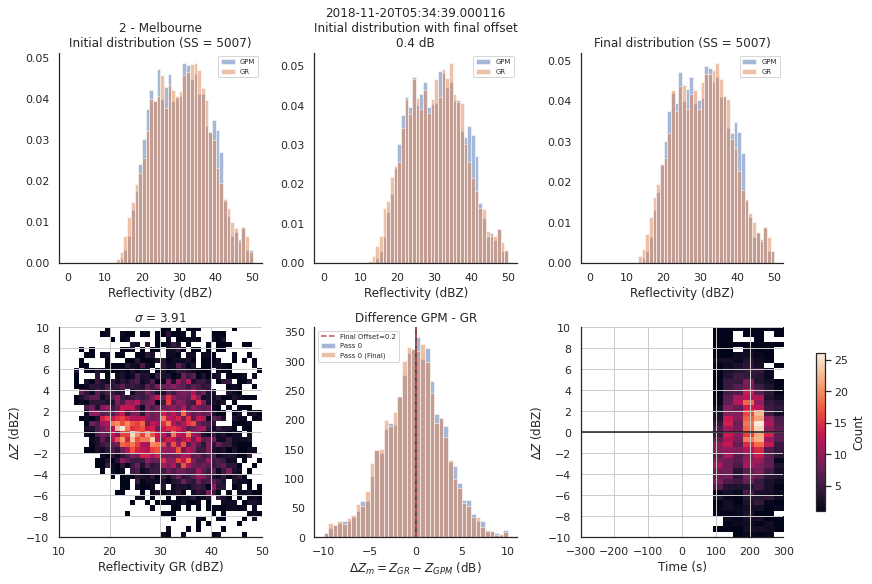

In [19]:
plot_stats("./output_data/final_pass/vmatch.gpm.orbit.0026860.Melbourne_radar.20181120.0536.pass0.nc")